In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use("ggplot")

pd.set_option('display.max_columns', None)

Load and merge the data.

In [94]:
path_13="../../data/Rockwell_Flow_Loop_Data/Flow_Loop_Data_071322_cleaned.csv"
path_14="../../data/Rockwell_Flow_Loop_Data/Flow_Loop_Data_071422_cleaned.csv"
path_15="../../data/Rockwell_Flow_Loop_Data/Flow_Loop_Data_071522_cleaned.csv"
path_17="../../data/Rockwell_Flow_Loop_Data/Flow_Loop_Data_071722_cleaned.csv"
path_18="../../data/Rockwell_Flow_Loop_Data/Flow_Loop_Data_071822_cleaned.csv"
path_19="../../data/Rockwell_Flow_Loop_Data/Flow_Loop_Data_071922_cleaned.csv"
path_20="../../data/Rockwell_Flow_Loop_Data/Flow_Loop_Data_072022_cleaned.csv"
path_21="../../data/Rockwell_Flow_Loop_Data/Flow_Loop_Data_072122_cleaned.csv"
path_22="../../data/Rockwell_Flow_Loop_Data/Flow_Loop_Data_072222_cleaned.csv"
path_25="../../data/Rockwell_Flow_Loop_Data/Flow_Loop_Data_072522_cleaned.csv"
path_26="../../data/Rockwell_Flow_Loop_Data/Flow_Loop_Data_072622_cleaned.csv"
path_27="../../data/Rockwell_Flow_Loop_Data/Flow_Loop_Data_072722_cleaned.csv"
path_28="../../data/Rockwell_Flow_Loop_Data/Flow_Loop_Data_072822_cleaned.csv"
path_29="../../data/Rockwell_Flow_Loop_Data/Flow_Loop_Data_072922_cleaned.csv"
path_01="../../data/Rockwell_Flow_Loop_Data/Flow_Loop_Data_080122_cleaned.csv"

In [95]:
data_13=pd.read_csv(path_13)
data_14=pd.read_csv(path_14)
data_15=pd.read_csv(path_15)
data_17=pd.read_csv(path_17)
data_18=pd.read_csv(path_18)
data_19=pd.read_csv(path_19)
data_20=pd.read_csv(path_20)
data_21=pd.read_csv(path_21)
data_22=pd.read_csv(path_22)
data_25=pd.read_csv(path_25)
data_26=pd.read_csv(path_26)
data_27=pd.read_csv(path_27)
data_28=pd.read_csv(path_28)
data_29=pd.read_csv(path_29)
data_01=pd.read_csv(path_01)

In [96]:
frames = [data_13,data_14,data_15,data_17,data_18,data_19,data_20,data_21,data_22,data_25,data_26,data_27,data_28,data_29,data_01]

In [97]:
data=pd.concat(frames)

Define the features and the target variable.

In [98]:
X=data[["FIT102_Raw_Signal","FIT202_Raw_Signal","LIT101_Raw_Signal","LIT201_Raw_Signal","PIT101_Raw_Signal","PIT102_Raw_Signal","PIT201_Raw_Signal","PIT202_Raw_Signal","SI102_Raw_Signal","SI202_Raw_Signal"]]
data["anomaly"]=data["event"]!="normal"
y=data[["anomaly"]]

In [99]:
from sklearn.model_selection import train_test_split, GridSearchCV

Create train and test dataset:

In [100]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 100)

In [101]:
X_train=X_train.copy()
X_val=X_val.copy()
y_train=y_train.anomaly
y_val=y_val.anomaly

In [102]:
from sklearn.preprocessing import StandardScaler
attributes=["FIT102_Raw_Signal","FIT202_Raw_Signal","LIT101_Raw_Signal","LIT201_Raw_Signal","PIT101_Raw_Signal","PIT102_Raw_Signal","PIT201_Raw_Signal","PIT202_Raw_Signal","SI102_Raw_Signal","SI202_Raw_Signal"]
scaler=StandardScaler()
scaler.fit(X_train[attributes])
X_train[attributes]=scaler.transform(X_train[attributes])
X_val[attributes]=scaler.transform(X_val[attributes])

In [103]:
#train a lasso and/or elastic model with logistic regression, using CV 

#the cv in glum for binomial is done (presumably) via deviance and not accuracy, but small deviance => good accuracy in principle
from glum import GeneralizedLinearRegressorCV

lin_reg=GeneralizedLinearRegressorCV(family="binomial", link="logit", cv=5, 
                                     min_alpha=0.00001, l1_ratio=[0.5,0.8, 0.9,1], 
                                     fit_intercept=True,
                                     max_iter=150)

lin_reg.fit(X_train[attributes],y_train)

/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/glum/_link.py:259: UserWarning: Computing sigmoid function gave results too close to 0 or 1. Clipping.
  warnings.warn(


GeneralizedLinearRegressorCV(cv=5, family='binomial',
                             l1_ratio=[0.5, 0.8, 0.9, 1], link='logit',
                             max_iter=150, min_alpha=1e-05)

In [104]:
print("alpha:", lin_reg.alpha_ ,", l1_ratio:", lin_reg.l1_ratio_)

alpha: 1.1013234700168535e-05 , l1_ratio: 0.8


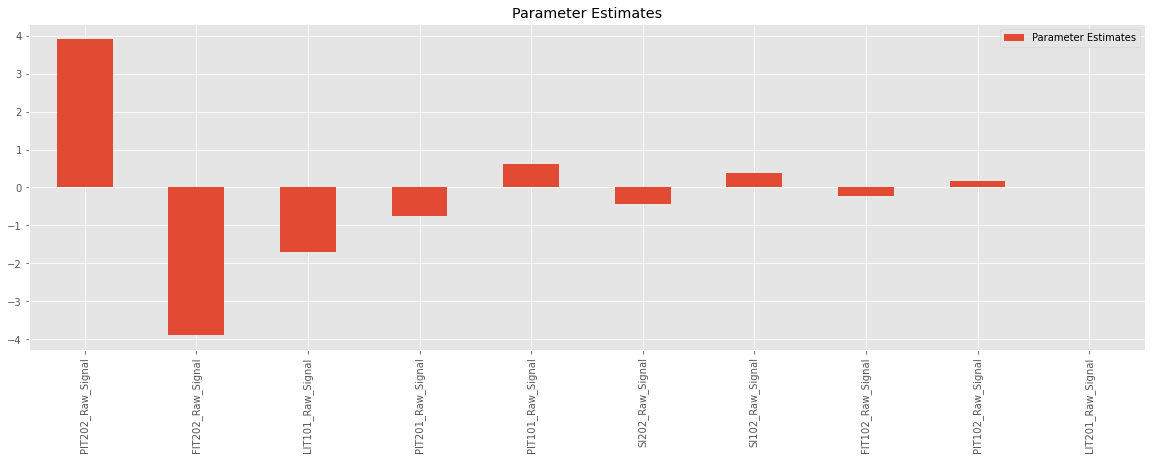

In [105]:
#plot the largest coefficients
coefs=pd.DataFrame(lin_reg.coef_, index=X_val[attributes].columns,columns=["Parameter Estimates"])
coefs.sort_values(by="Parameter Estimates",key=abs,ascending=False).plot(kind="bar",figsize=(20,6));
plt.title("Parameter Estimates");

In [106]:
#Baseline accuracy by always guessing no error:
print("The Baseline error is:",round(np.sum(y_val)/len(y_val)*100,2), "%")

The Baseline error is: 20.37 %


In [107]:
y_hat_val=(lin_reg.predict(X_val[attributes])>=0.5)
from sklearn.metrics import accuracy_score
print("Accuracy is", round(accuracy_score(y_hat_val,y_val)*100,2), "%", )

Accuracy is 85.12 %


/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/glum/_link.py:259: UserWarning: Computing sigmoid function gave results too close to 0 or 1. Clipping.
  warnings.warn(


In [108]:
y_baseline=np.zeros(len(y_val))
from sklearn.metrics import f1_score
print("F1 score of baseline is", f1_score(y_val,y_baseline))
print("F1 score of glm lasso is", f1_score(y_val,y_hat_val))

F1 score of baseline is 0.0
F1 score of glm lasso is 0.47622326038849283


Now run XGBoost instead:

In [109]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb=XGBClassifier(objective="binary:logistic",use_label_encoder=False)
parameters={"n_estimators":[100], "learning_rate":[0.1], "max_depth":[6], "gamma":[0.1]}

xgb_cv=GridSearchCV(xgb, parameters, scoring="accuracy",cv=2)
xgb_cv.fit(X_train,y_train)

print("Best parameters:", xgb_cv.best_params_ , ", Best CV Accuracy:", xgb_cv.best_score_)

Best parameters: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100} , Best CV Accuracy: 0.9670831062479912


In [110]:
#prediction
y_hat=xgb_cv.best_estimator_.predict(X_val)
print("XGBC has test accuracy", round(100*(accuracy_score(y_hat,y_val)),2), "%")

XGBC has test accuracy 96.69 %


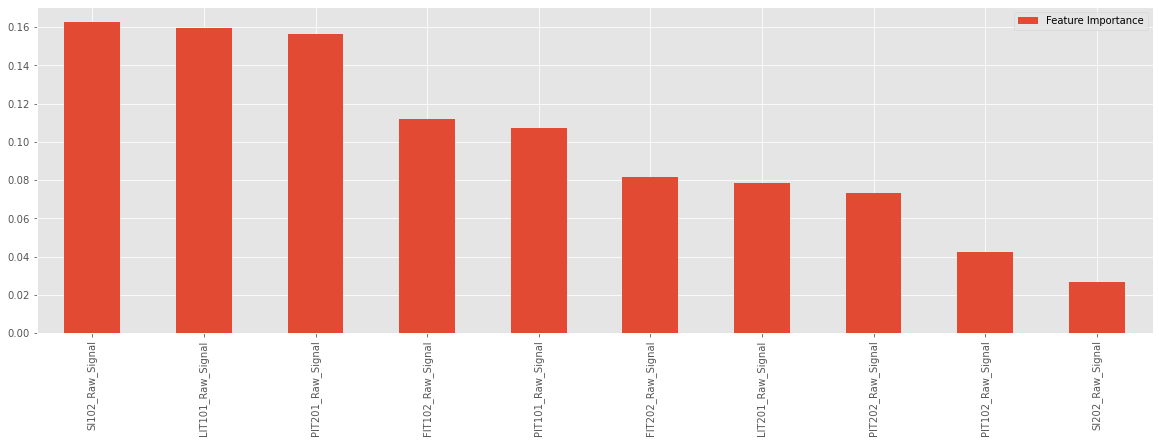

In [111]:
#plot feature importance of xgb
importance_df=pd.DataFrame(xgb_cv.best_estimator_.feature_importances_, 
                           index=X_train.columns, columns=["Feature Importance"])

importance_df.sort_values(by="Feature Importance", ascending=False).head(10).plot(kind="bar",figsize=(20,6));

In [112]:
y_baseline=np.zeros(len(y_val))

from sklearn.metrics import f1_score

print("F1 score of baseline is", f1_score(y_val,y_baseline, average="macro"))
print("F1 score of xgb is", f1_score(y_val,y_hat, average="macro"))
print("F1 score of baseline is", f1_score(y_val,y_baseline))
print("F1 score of xgb is", f1_score(y_val,y_hat))

F1 score of baseline is 0.44329824725184963
F1 score of xgb is 0.9460528961761556
F1 score of baseline is 0.0
F1 score of xgb is 0.9125216941767291


Now we introduce the means of the gradients. For this, we load the full dataset: 

In [113]:
path="../../data/Rockwell_Flow_Loop_Data/final_columns.csv"
data=pd.read_csv(path)
data.head(5)

,Unnamed: 0,max_FIT102_Raw_Signal,min_FIT102_Raw_Signal,mean_FIT102_Raw_Signal,std_FIT102_Raw_Signal,max_FIT202_Raw_Signal,min_FIT202_Raw_Signal,mean_FIT202_Raw_Signal,std_FIT202_Raw_Signal,max_LIT101_Raw_Signal,min_LIT101_Raw_Signal,mean_LIT101_Raw_Signal,std_LIT101_Raw_Signal,max_LIT201_Raw_Signal,min_LIT201_Raw_Signal,mean_LIT201_Raw_Signal,std_LIT201_Raw_Signal,max_PIT101_Raw_Signal,min_PIT101_Raw_Signal,mean_PIT101_Raw_Signal,std_PIT101_Raw_Signal,max_PIT102_Raw_Signal,min_PIT102_Raw_Signal,mean_PIT102_Raw_Signal,std_PIT102_Raw_Signal,max_PIT201_Raw_Signal,min_PIT201_Raw_Signal,mean_PIT201_Raw_Signal,std_PIT201_Raw_Signal,max_PIT202_Raw_Signal,min_PIT202_Raw_Signal,mean_PIT202_Raw_Signal,std_PIT202_Raw_Signal,max_SI102_Raw_Signal,min_SI102_Raw_Signal,mean_SI102_Raw_Signal,std_SI102_Raw_Signal,max_SI202_Raw_Signal,min_SI202_Raw_Signal,mean_SI202_Raw_Signal,std_SI202_Raw_Signal,event,binary,ternary
0,2022-07-13 09:13:09,4.30,-4.28,-0.248235,2.485488,2.68,-4.32,-0.040000,1.948820,2.50,-2.28,-0.052941,1.501149,0.32,-0.32,-0.032941,0.235366,0.10,-0.18,0.002353,0.077098,1.04,-1.00,-2.612289e-17,0.648151,0.36,-0.80,-0.020000,0.320624,0.44,-0.46,0.008235,0.281164,4.60,-5.52,0.112941,3.532336,3.36,-3.78,0.144706,2.021256,normal,normal,normal
1,2022-07-13 09:13:39,4.58,-3.32,0.001176,2.543123,2.26,-5.88,-0.301176,2.072203,2.56,-2.54,-0.140000,1.460856,0.38,-0.32,0.014118,0.248572,0.18,-0.18,0.002353,0.093777,0.76,-1.00,-1.764706e-02,0.500843,0.32,-0.52,-0.001176,0.270414,0.60,-0.68,0.010588,0.337870,4.60,-5.52,-0.005882,2.935633,5.50,-4.86,0.216471,2.585239,normal,normal,normal
2,2022-07-13 09:14:09,5.10,-3.80,0.071765,2.814365,5.16,-5.88,-0.015294,2.419654,2.56,-2.54,-0.109412,1.563699,0.38,-0.32,0.038824,0.231460,0.18,-0.16,-0.007059,0.072091,0.76,-1.18,-2.941176e-02,0.583186,0.30,-0.40,0.004706,0.209944,0.60,-0.68,-0.031765,0.301169,4.52,-7.34,-0.094118,3.015840,5.50,-4.86,0.003529,2.354902,normal,normal,normal
3,2022-07-13 09:14:39,5.10,-3.80,-0.042353,2.228765,5.16,-5.88,0.134118,2.475508,1.86,-2.54,-0.074118,1.471713,0.38,-0.50,0.008235,0.209411,0.18,-0.16,-0.001176,0.086450,0.68,-1.18,1.176471e-02,0.474608,0.30,-0.40,-0.005882,0.227130,0.60,-0.68,-0.003529,0.346355,3.32,-7.34,0.070588,2.370318,5.50,-4.86,0.007059,2.695959,normal,normal,normal
4,2022-07-13 09:15:09,5.10,-3.80,0.175294,2.095346,2.74,-3.54,-0.143529,1.719989,1.86,-1.64,-0.080000,1.341343,0.34,-0.50,0.012941,0.201115,0.20,-0.12,0.007059,0.084244,3.44,-1.18,2.141176e-01,0.952070,0.60,-0.46,-0.008235,0.258849,0.58,-0.90,0.010588,0.390904,2.88,-7.34,-0.021176,2.296775,4.10,-4.10,-0.045882,2.096411,normal,normal,normal


In [114]:
X_full=data[["max_FIT102_Raw_Signal","min_FIT102_Raw_Signal","mean_FIT102_Raw_Signal","std_FIT102_Raw_Signal","max_FIT202_Raw_Signal","min_FIT202_Raw_Signal","mean_FIT202_Raw_Signal","std_FIT202_Raw_Signal","max_LIT101_Raw_Signal","min_LIT101_Raw_Signal","mean_LIT101_Raw_Signal","std_LIT101_Raw_Signal","max_LIT201_Raw_Signal","min_LIT201_Raw_Signal","mean_LIT201_Raw_Signal","std_LIT201_Raw_Signal","max_PIT101_Raw_Signal","min_PIT101_Raw_Signal","mean_PIT101_Raw_Signal","std_PIT101_Raw_Signal","max_PIT102_Raw_Signal","min_PIT102_Raw_Signal","mean_PIT102_Raw_Signal","std_PIT102_Raw_Signal","max_PIT201_Raw_Signal","min_PIT201_Raw_Signal","mean_PIT201_Raw_Signal","std_PIT201_Raw_Signal","max_PIT202_Raw_Signal","min_PIT202_Raw_Signal","mean_PIT202_Raw_Signal","std_PIT202_Raw_Signal","max_SI102_Raw_Signal","min_SI102_Raw_Signal","mean_SI102_Raw_Signal","std_SI102_Raw_Signal","max_SI202_Raw_Signal","min_SI202_Raw_Signal","mean_SI202_Raw_Signal","std_SI202_Raw_Signal"]]
X_full_std=data[["mean_FIT102_Raw_Signal","std_FIT102_Raw_Signal","mean_FIT202_Raw_Signal","std_FIT202_Raw_Signal","mean_LIT101_Raw_Signal","std_LIT101_Raw_Signal","mean_LIT201_Raw_Signal","std_LIT201_Raw_Signal","mean_PIT101_Raw_Signal","std_PIT101_Raw_Signal","mean_PIT102_Raw_Signal","std_PIT102_Raw_Signal","mean_PIT201_Raw_Signal","std_PIT201_Raw_Signal","mean_PIT202_Raw_Signal","std_PIT202_Raw_Signal","mean_SI102_Raw_Signal","std_SI102_Raw_Signal","mean_SI202_Raw_Signal","std_SI202_Raw_Signal"]]
data["anomaly"]=data["event"]!="normal"
y_full=data[["anomaly"]]

In [115]:
X_train_full_std, X_test_full_std, y_train_full, y_test_full = train_test_split(X_full_std, y_full, test_size = 0.20, random_state = 100)

In [116]:
X_train_full_std=X_train_full_std.copy()
X_test_full_std=X_test_full_std.copy()
y_train_full=y_train_full.anomaly
y_test_full=y_test_full.anomaly

In [117]:
attributes=["mean_FIT102_Raw_Signal","std_FIT102_Raw_Signal","mean_FIT202_Raw_Signal","std_FIT202_Raw_Signal","mean_LIT101_Raw_Signal","std_LIT101_Raw_Signal","mean_LIT201_Raw_Signal","std_LIT201_Raw_Signal","mean_PIT101_Raw_Signal","std_PIT101_Raw_Signal","mean_PIT102_Raw_Signal","std_PIT102_Raw_Signal","mean_PIT201_Raw_Signal","std_PIT201_Raw_Signal","mean_PIT202_Raw_Signal","std_PIT202_Raw_Signal","mean_SI102_Raw_Signal","std_SI102_Raw_Signal","mean_SI202_Raw_Signal","std_SI202_Raw_Signal"]
scaler=StandardScaler()
scaler.fit(X_train_full_std[attributes])
X_train_full_std[attributes]=scaler.transform(X_train_full_std[attributes])
X_test_full_std[attributes]=scaler.transform(X_test_full_std[attributes])

In [118]:
#train a lasso and/or elastic model with logistic regression, using CV 

#the cv in glum for binomial is done (presumably) via deviance and not accuracy, but small deviance => good accuracy in principle
from glum import GeneralizedLinearRegressorCV

lin_reg2=GeneralizedLinearRegressorCV(family="binomial", link="logit", cv=5, 
                                     min_alpha=0.000001, l1_ratio=[0.5,0.8, 0.9,1], 
                                     fit_intercept=True,
                                     max_iter=150)

lin_reg2.fit(X_train_full[attributes],y_train_full)

GeneralizedLinearRegressorCV(cv=5, family='binomial',
                             l1_ratio=[0.5, 0.8, 0.9, 1], link='logit',
                             max_iter=150, min_alpha=1e-06)

In [121]:
print("alpha:", lin_reg2.alpha_ ,", l1_ratio:", lin_reg2.l1_ratio_)

alpha: 0.002832253123845142 , l1_ratio: 0.5


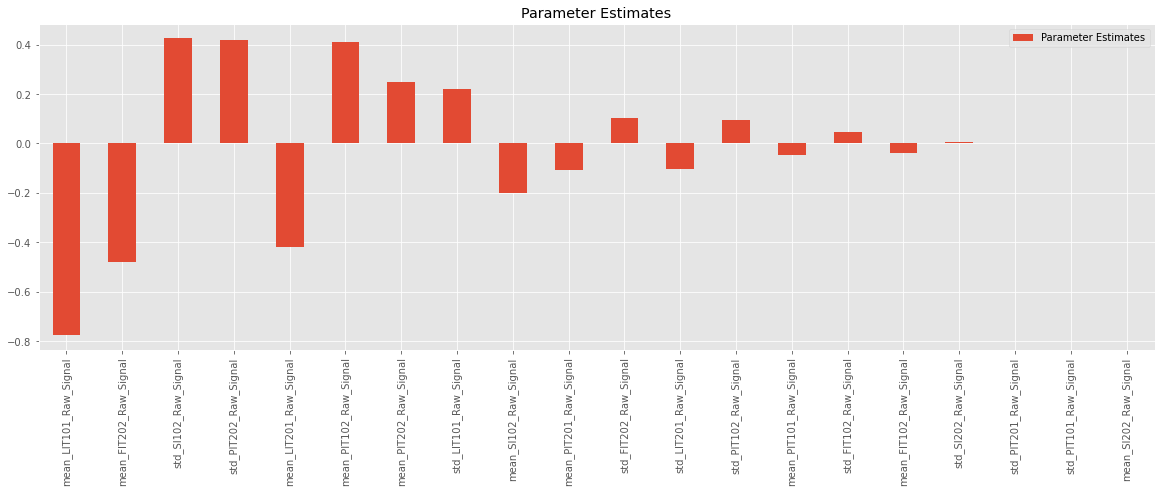

In [123]:
#plot the largest coefficients
coefs=pd.DataFrame(lin_reg2.coef_, index=X_test_full_std[attributes].columns,columns=["Parameter Estimates"])
coefs.sort_values(by="Parameter Estimates",key=abs,ascending=False).plot(kind="bar",figsize=(20,6));
plt.title("Parameter Estimates");

In [124]:
#Baseline accuracy by always guessing no error:
print("The Baseline error is:",round(np.sum(y_test_full)/len(y_test_full)*100,2), "%")

The Baseline error is: 20.73 %


In [126]:
y_hat_test_full=(lin_reg2.predict(X_test_full_std[attributes])>=0.5)
from sklearn.metrics import accuracy_score
print("Accuracy is", round(accuracy_score(y_hat_test_full,y_test_full)*100,2), "%", )

Accuracy is 86.13 %


In [127]:
y_baseline=np.zeros(len(y_test_full))
from sklearn.metrics import f1_score
print("F1 score of baseline is", f1_score(y_test_full,y_baseline))
print("F1 score of glm lasso is", f1_score(y_test_full,y_hat_test_full))

F1 score of baseline is 0.0
F1 score of glm lasso is 0.5283505154639175


In [128]:
#print classification report
from sklearn.metrics import classification_report, plot_confusion_matrix
print('Classification report')
print(classification_report(y_test_full, y_hat_test_full))
print('\n')

Classification report
              precision    recall  f1-score   support

       False       0.86      0.99      0.92      2092
        True       0.90      0.37      0.53       547

    accuracy                           0.86      2639
   macro avg       0.88      0.68      0.72      2639
weighted avg       0.87      0.86      0.84      2639





In [129]:
xgb2=XGBClassifier(objective="binary:logistic",use_label_encoder=False)
parameters={"n_estimators":[100], "learning_rate":[0.1], "max_depth":[6], "gamma":[0.1]}

xgb_cv2=GridSearchCV(xgb2, parameters, scoring="accuracy",cv=2)
xgb_cv2.fit(X_train_full_std,y_train_full)

print("Best parameters:", xgb_cv2.best_params_ , ", Best CV Accuracy:", xgb_cv2.best_score_)

Best parameters: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100} , Best CV Accuracy: 0.939649409812708


In [134]:
#prediction
y_hat_full_xgb=xgb_cv2.best_estimator_.predict(X_test_full_std)
print("XGBC has test accuracy", round(100*(accuracy_score(y_hat_full_xgb,y_test_full)),2), "%")

XGBC has test accuracy 95.53 %


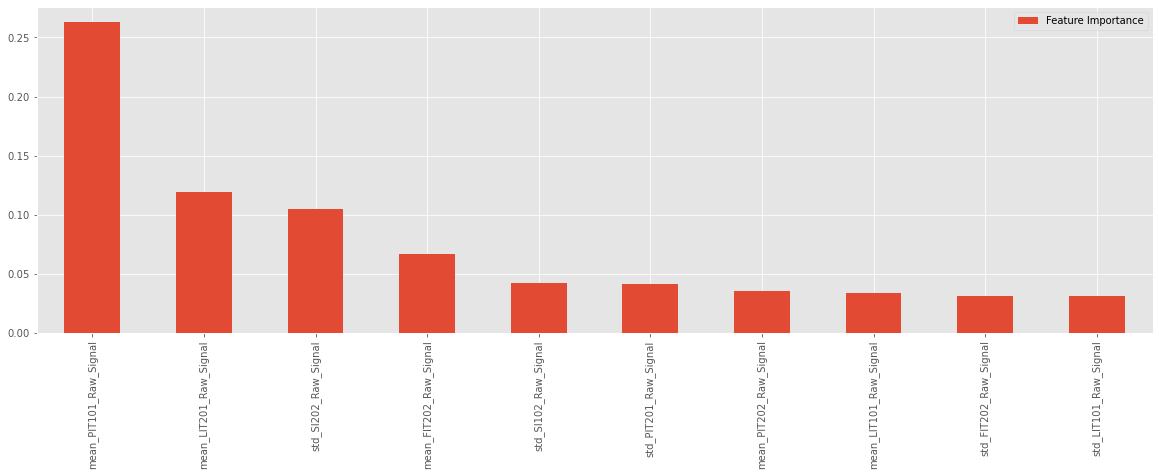

In [135]:
#plot feature importance of xgb
importance_df=pd.DataFrame(xgb_cv2.best_estimator_.feature_importances_, 
                           index=X_train_full_std.columns, columns=["Feature Importance"])

importance_df.sort_values(by="Feature Importance", ascending=False).head(10).plot(kind="bar",figsize=(20,6));

In [137]:
y_baseline=np.zeros(len(y_test_full))
print("F1 score of baseline is", f1_score(y_test_full,y_baseline, average="macro"))
print("F1 score of xgb is", f1_score(y_test_full,y_hat_full_xgb, average="macro"))
print("F1 score of baseline is", f1_score(y_test_full,y_baseline))
print("F1 score of xgb is", f1_score(y_test_full,y_hat_full_xgb))

F1 score of baseline is 0.44218981187909534
F1 score of xgb is 0.9292448285890864
F1 score of baseline is 0.0
F1 score of xgb is 0.8863198458574181


In [138]:
#print classification report
from sklearn.metrics import classification_report, plot_confusion_matrix
print('Classification report')
print(classification_report(y_test_full, y_hat_full_xgb))
print('\n')

Classification report
              precision    recall  f1-score   support

       False       0.96      0.99      0.97      2092
        True       0.94      0.84      0.89       547

    accuracy                           0.96      2639
   macro avg       0.95      0.91      0.93      2639
weighted avg       0.95      0.96      0.95      2639





In [140]:
# Now with all the features
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size = 0.20, random_state = 100)
X_train_full=X_train_full.copy()
X_test_full=X_test_full.copy()
y_train_full=y_train_full.anomaly
y_test_full=y_test_full.anomaly

#Standard scaler 
attributes=["max_FIT102_Raw_Signal","min_FIT102_Raw_Signal","mean_FIT102_Raw_Signal","std_FIT102_Raw_Signal","max_FIT202_Raw_Signal","min_FIT202_Raw_Signal","mean_FIT202_Raw_Signal","std_FIT202_Raw_Signal","max_LIT101_Raw_Signal","min_LIT101_Raw_Signal","mean_LIT101_Raw_Signal","std_LIT101_Raw_Signal","max_LIT201_Raw_Signal","min_LIT201_Raw_Signal","mean_LIT201_Raw_Signal","std_LIT201_Raw_Signal","max_PIT101_Raw_Signal","min_PIT101_Raw_Signal","mean_PIT101_Raw_Signal","std_PIT101_Raw_Signal","max_PIT102_Raw_Signal","min_PIT102_Raw_Signal","mean_PIT102_Raw_Signal","std_PIT102_Raw_Signal","max_PIT201_Raw_Signal","min_PIT201_Raw_Signal","mean_PIT201_Raw_Signal","std_PIT201_Raw_Signal","max_PIT202_Raw_Signal","min_PIT202_Raw_Signal","mean_PIT202_Raw_Signal","std_PIT202_Raw_Signal","max_SI102_Raw_Signal","min_SI102_Raw_Signal","mean_SI102_Raw_Signal","std_SI102_Raw_Signal","max_SI202_Raw_Signal","min_SI202_Raw_Signal","mean_SI202_Raw_Signal","std_SI202_Raw_Signal"]
scaler=StandardScaler()
scaler.fit(X_train_full[attributes])
X_train_full[attributes]=scaler.transform(X_train_full[attributes])
X_test_full[attributes]=scaler.transform(X_test_full[attributes])

xgb3=XGBClassifier(objective="binary:logistic",use_label_encoder=False)
parameters={"n_estimators":[100], "learning_rate":[0.1], "max_depth":[6], "gamma":[0.1]}

xgb_cv3=GridSearchCV(xgb3, parameters, scoring="accuracy",cv=2)
xgb_cv3.fit(X_train_full,y_train_full)

print("Best parameters:", xgb_cv.best_params_ , ", Best CV Accuracy:", xgb_cv3.best_score_)

Best parameters: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100} , Best CV Accuracy: 0.9517763998758294


In [141]:
#prediction
y_hat_full_xgb3=xgb_cv3.best_estimator_.predict(X_test_full)
print("XGBC has test accuracy", round(100*(accuracy_score(y_hat_full_xgb3,y_test_full)),2), "%")

XGBC has test accuracy 96.89 %


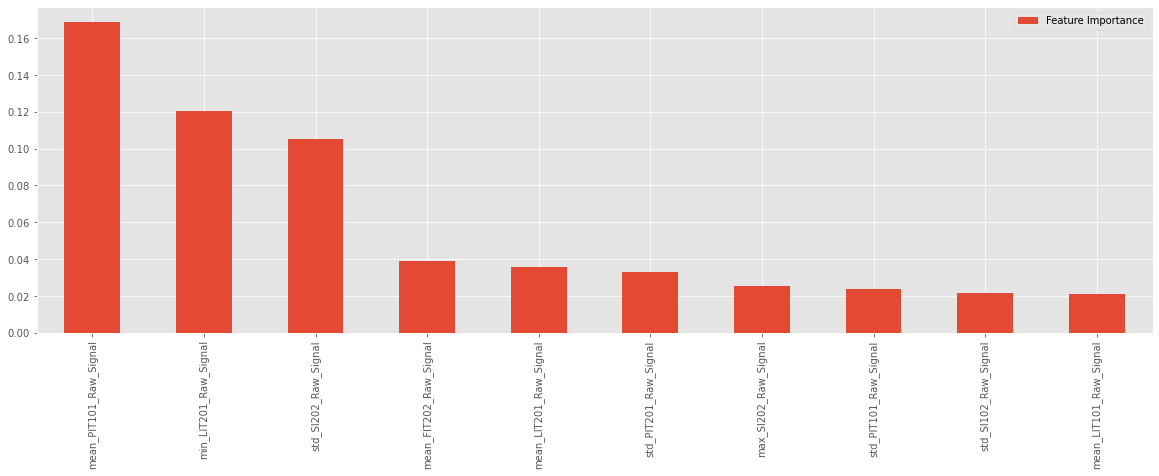

In [142]:
#plot feature importance of xgb
importance_df=pd.DataFrame(xgb_cv3.best_estimator_.feature_importances_, 
                           index=X_train_full.columns, columns=["Feature Importance"])

importance_df.sort_values(by="Feature Importance", ascending=False).head(10).plot(kind="bar",figsize=(20,6));

In [144]:
y_baseline=np.zeros(len(y_test_full))
print("F1 score of baseline is", f1_score(y_test_full,y_baseline, average="macro"))
print("F1 score of xgb is", f1_score(y_test_full,y_hat_full_xgb3, average="macro"))
print("F1 score of baseline is", f1_score(y_test_full,y_baseline))
print("F1 score of xgb is", f1_score(y_test_full,y_hat_full_xgb3))

F1 score of baseline is 0.44218981187909534
F1 score of xgb is 0.9513247702525918
F1 score of baseline is 0.0
F1 score of xgb is 0.9220532319391636


In [145]:
#print classification report
from sklearn.metrics import classification_report, plot_confusion_matrix
print('Classification report')
print(classification_report(y_test_full, y_hat_full_xgb3))
print('\n')

Classification report
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      2092
        True       0.96      0.89      0.92       547

    accuracy                           0.97      2639
   macro avg       0.97      0.94      0.95      2639
weighted avg       0.97      0.97      0.97      2639



